# Erythroid lineage

## 1. Loading packages

In [1]:
import sys
sys.path = [".."] + sys.path # cd to the velovgi project path

import numpy as np
import matplotlib.pyplot as plt

import scvelo as scv
import velovgi

from pytorch_lightning import loggers
from torch_geometric import seed_everything

seed = 0
seed_everything(seed)

Global seed set to 0
/home/huang/.conda/envs/velovgi/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/huang/.conda/envs/velovgi/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## 2. Loading anndata object

The ideal estimated direction of differentiation: Blood progenitors 1 -> Blood progenitors 2 -> Erythroid 1 -> Erythroid 2 -> Erythroid 3 

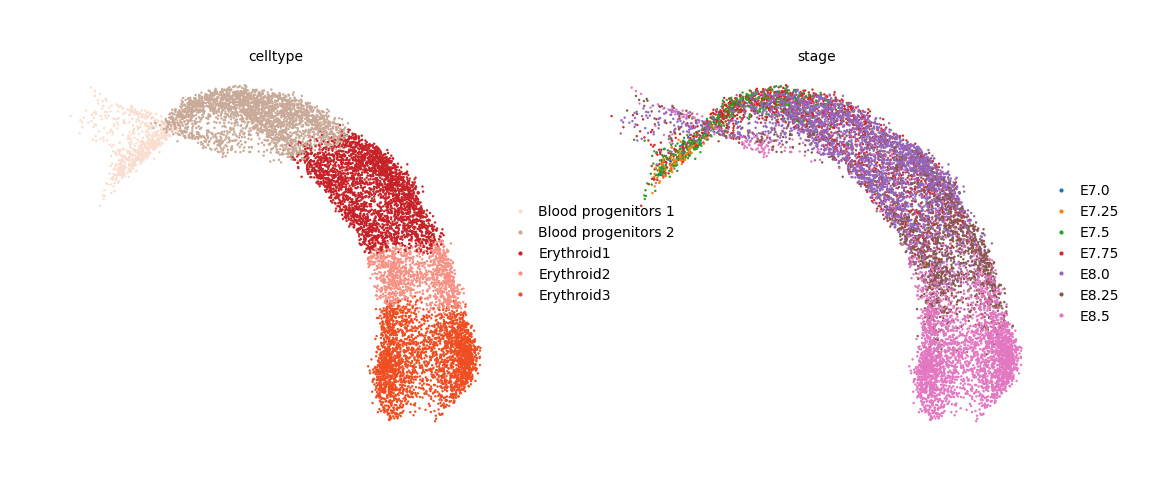

AnnData object with n_obs × n_vars = 9815 × 53801
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm'
    uns: 'celltype_colors', 'stage_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

In [21]:
adata = scv.datasets.gastrulation_erythroid("/home/huang/PyCode/scRNA/data/Gastrulation/erythroid_lineage.h5ad")
batch_key = "stage" # the column name identifing batch in obs
cluster_key = "celltype" # the column name identifing cluster in obs
scv.pl.umap(adata, color=[cluster_key, batch_key], legend_loc="right")
adata

## 3. Preprocessing Data

The preprocessing process includes:
- quality control
- normalization
- hvg(highly variable gene) selection
- pca
- neighborhood construction between adjacent batches in time series
- moment

In [5]:
subsample_adata = velovgi.pp.preprocess(adata, sample_mode="random", batch_key=batch_key)

Filtered out 47456 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
use_rep : X_pca
batch_pair_list : [('E7.0', 'E7.25'), ('E7.25', 'E7.5'), ('E7.5', 'E7.75'), ('E7.75', 'E8.0'), ('E8.0', 'E8.25'), ('E8.25', 'E8.5')]
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## 4. Training VeloVGI model and export result

VeloVGI can be trained with scvi-tools styles.

In [6]:
logger = loggers.TensorBoardLogger(save_dir="./log", name="base") # TensorBoard logging file
velovgi.tl.VELOVGI.setup_anndata(adata=subsample_adata, spliced_layer="Ms", unspliced_layer="Mu")
velovgi_model = velovgi.tl.VELOVGI(subsample_adata)
velovgi_model.train(logger=logger)

初始训练，初始化runner参数
choosing neighbor minibatch


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [04:30<00:00,  1.85it/s, loss=-2.66e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [04:30<00:00,  1.85it/s, loss=-2.66e+03, v_num=1]


The  parameters related to RNA velocity can be exported from VeloVGI model to Anndata object, such as transcription rates $\alpha$, splicing rates $\beta$, degradation rates $\gamma$.

In [7]:
velovgi.tl.add_velovi_outputs_to_adata(subsample_adata, velovgi_model) # 模型输出
velovgi.pp.moment_recover(adata, subsample_adata) # 恢复
subsample_adata, adata

(AnnData object with n_obs × n_vars = 4907 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling'
     uns: 'celltype_colors', 'neighbors', '_scvi_uuid', '_scvi_manager_uuid'
     obsm: 'X_pca', 'X_umap'
     layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'velocity_u', 'latent_time_velovgi', 'fit_t'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 9815 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 

## 5. Visualization

### 5.1 Stream plot

RNA velocity stream plot can be visualized.

computing velocity graph (using 1/24 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:10) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


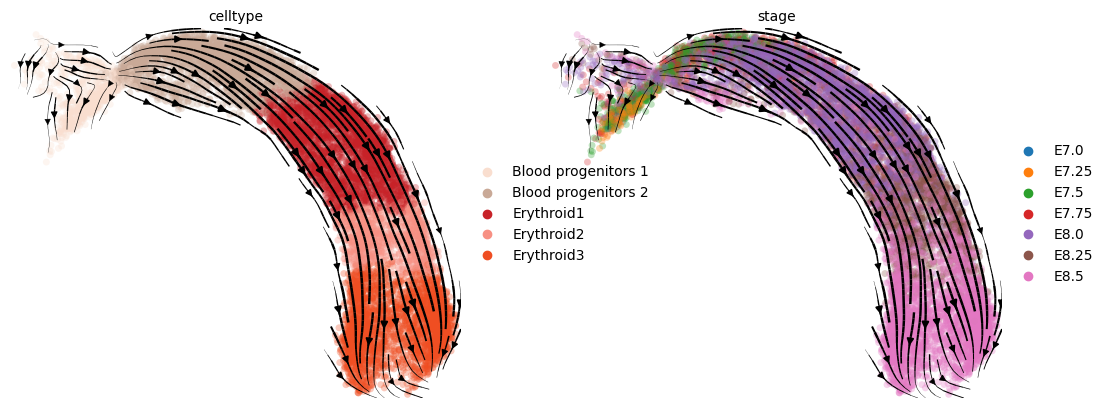

In [8]:
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color=[cluster_key, batch_key], legend_loc="right")

### 5.2 Hierarchical embedding

Hierarchical embedding  shows heterogeneity of cell types in each batch.

<Axes: title={'center': 'celltype'}, xlabel='X_umap_transformed_batch1', ylabel='X_umap_transformed_batch2'>

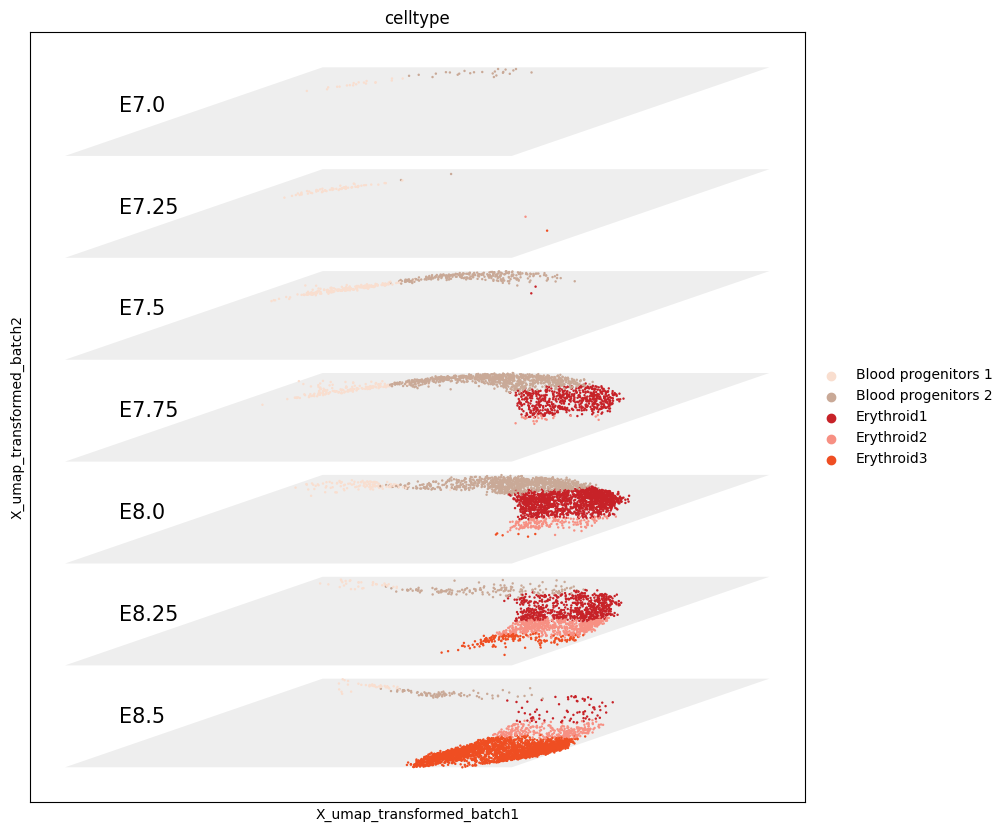

In [10]:
figsize=(10,10)
fig, ax = plt.subplots(figsize=figsize)

transform_matrix_params = dict(p=0.5, q=2 , theta=np.pi/20) # transition matrix parameters
sep = 25 # hierarchical gap parameters
embedding_plot_params = dict() # scatter plot parameters

velovgi.pl.draw_batch_layer_embedding(adata, cluster_key=cluster_key, batch_key=batch_key, transform_matrix_params=transform_matrix_params, sep=sep, embedding_plot_params=embedding_plot_params, ax=ax)

The 3D interactive graph allow for more visualization of batch-to-batch differences.

In [11]:
velovgi.pl.draw_batch_layer_embedding_3d(adata, cluster_key=cluster_key, batch_key=batch_key, size=3)

### 5.3 Neighborhood visualization

The batches are arranged clockwise on the circos plot, and the thickness of the bands between batches represents the number of neighbors between batches.

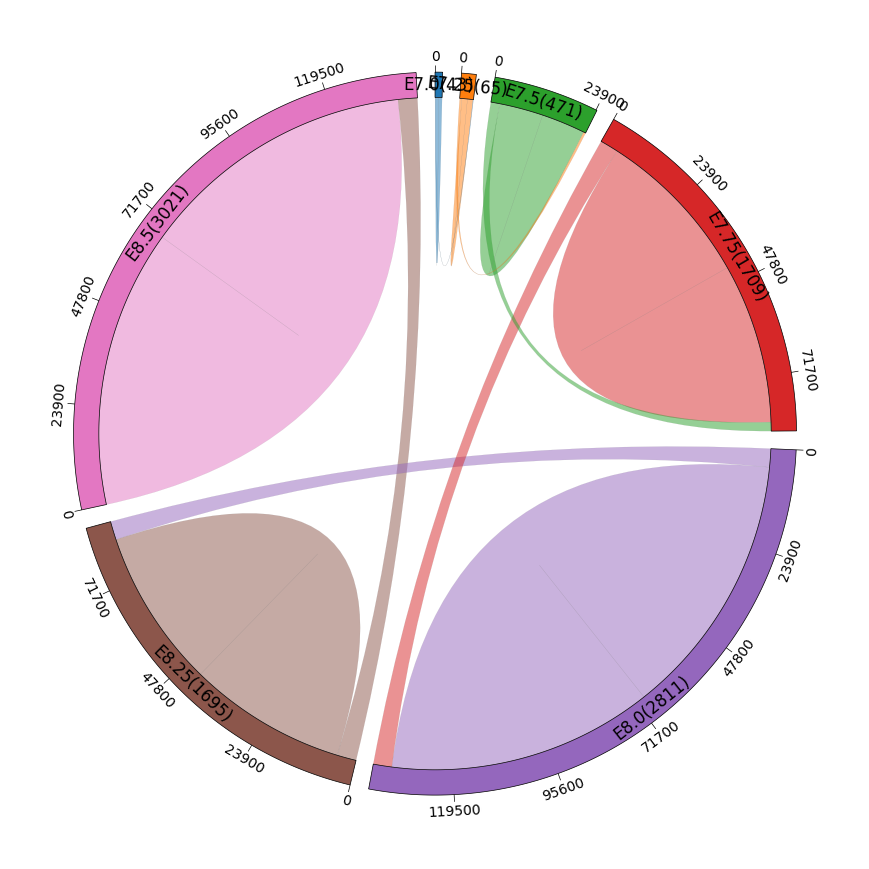

In [13]:
velovgi.pl.draw_batch_circos_ax(adata, batch_key=batch_key)

The number of internal (knn) neighbors per batch and the number of external (bnn) neighbors between batches are shown numerically in the umap plot, respectively.

/home/huang/PyCode/scRNA/Other/velovgi_workstation/notebook/../velovgi/plotting/draw_batch.py:121: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.

/home/huang/PyCode/scRNA/Other/velovgi_workstation/notebook/../velovgi/plotting/draw_batch.py:126: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



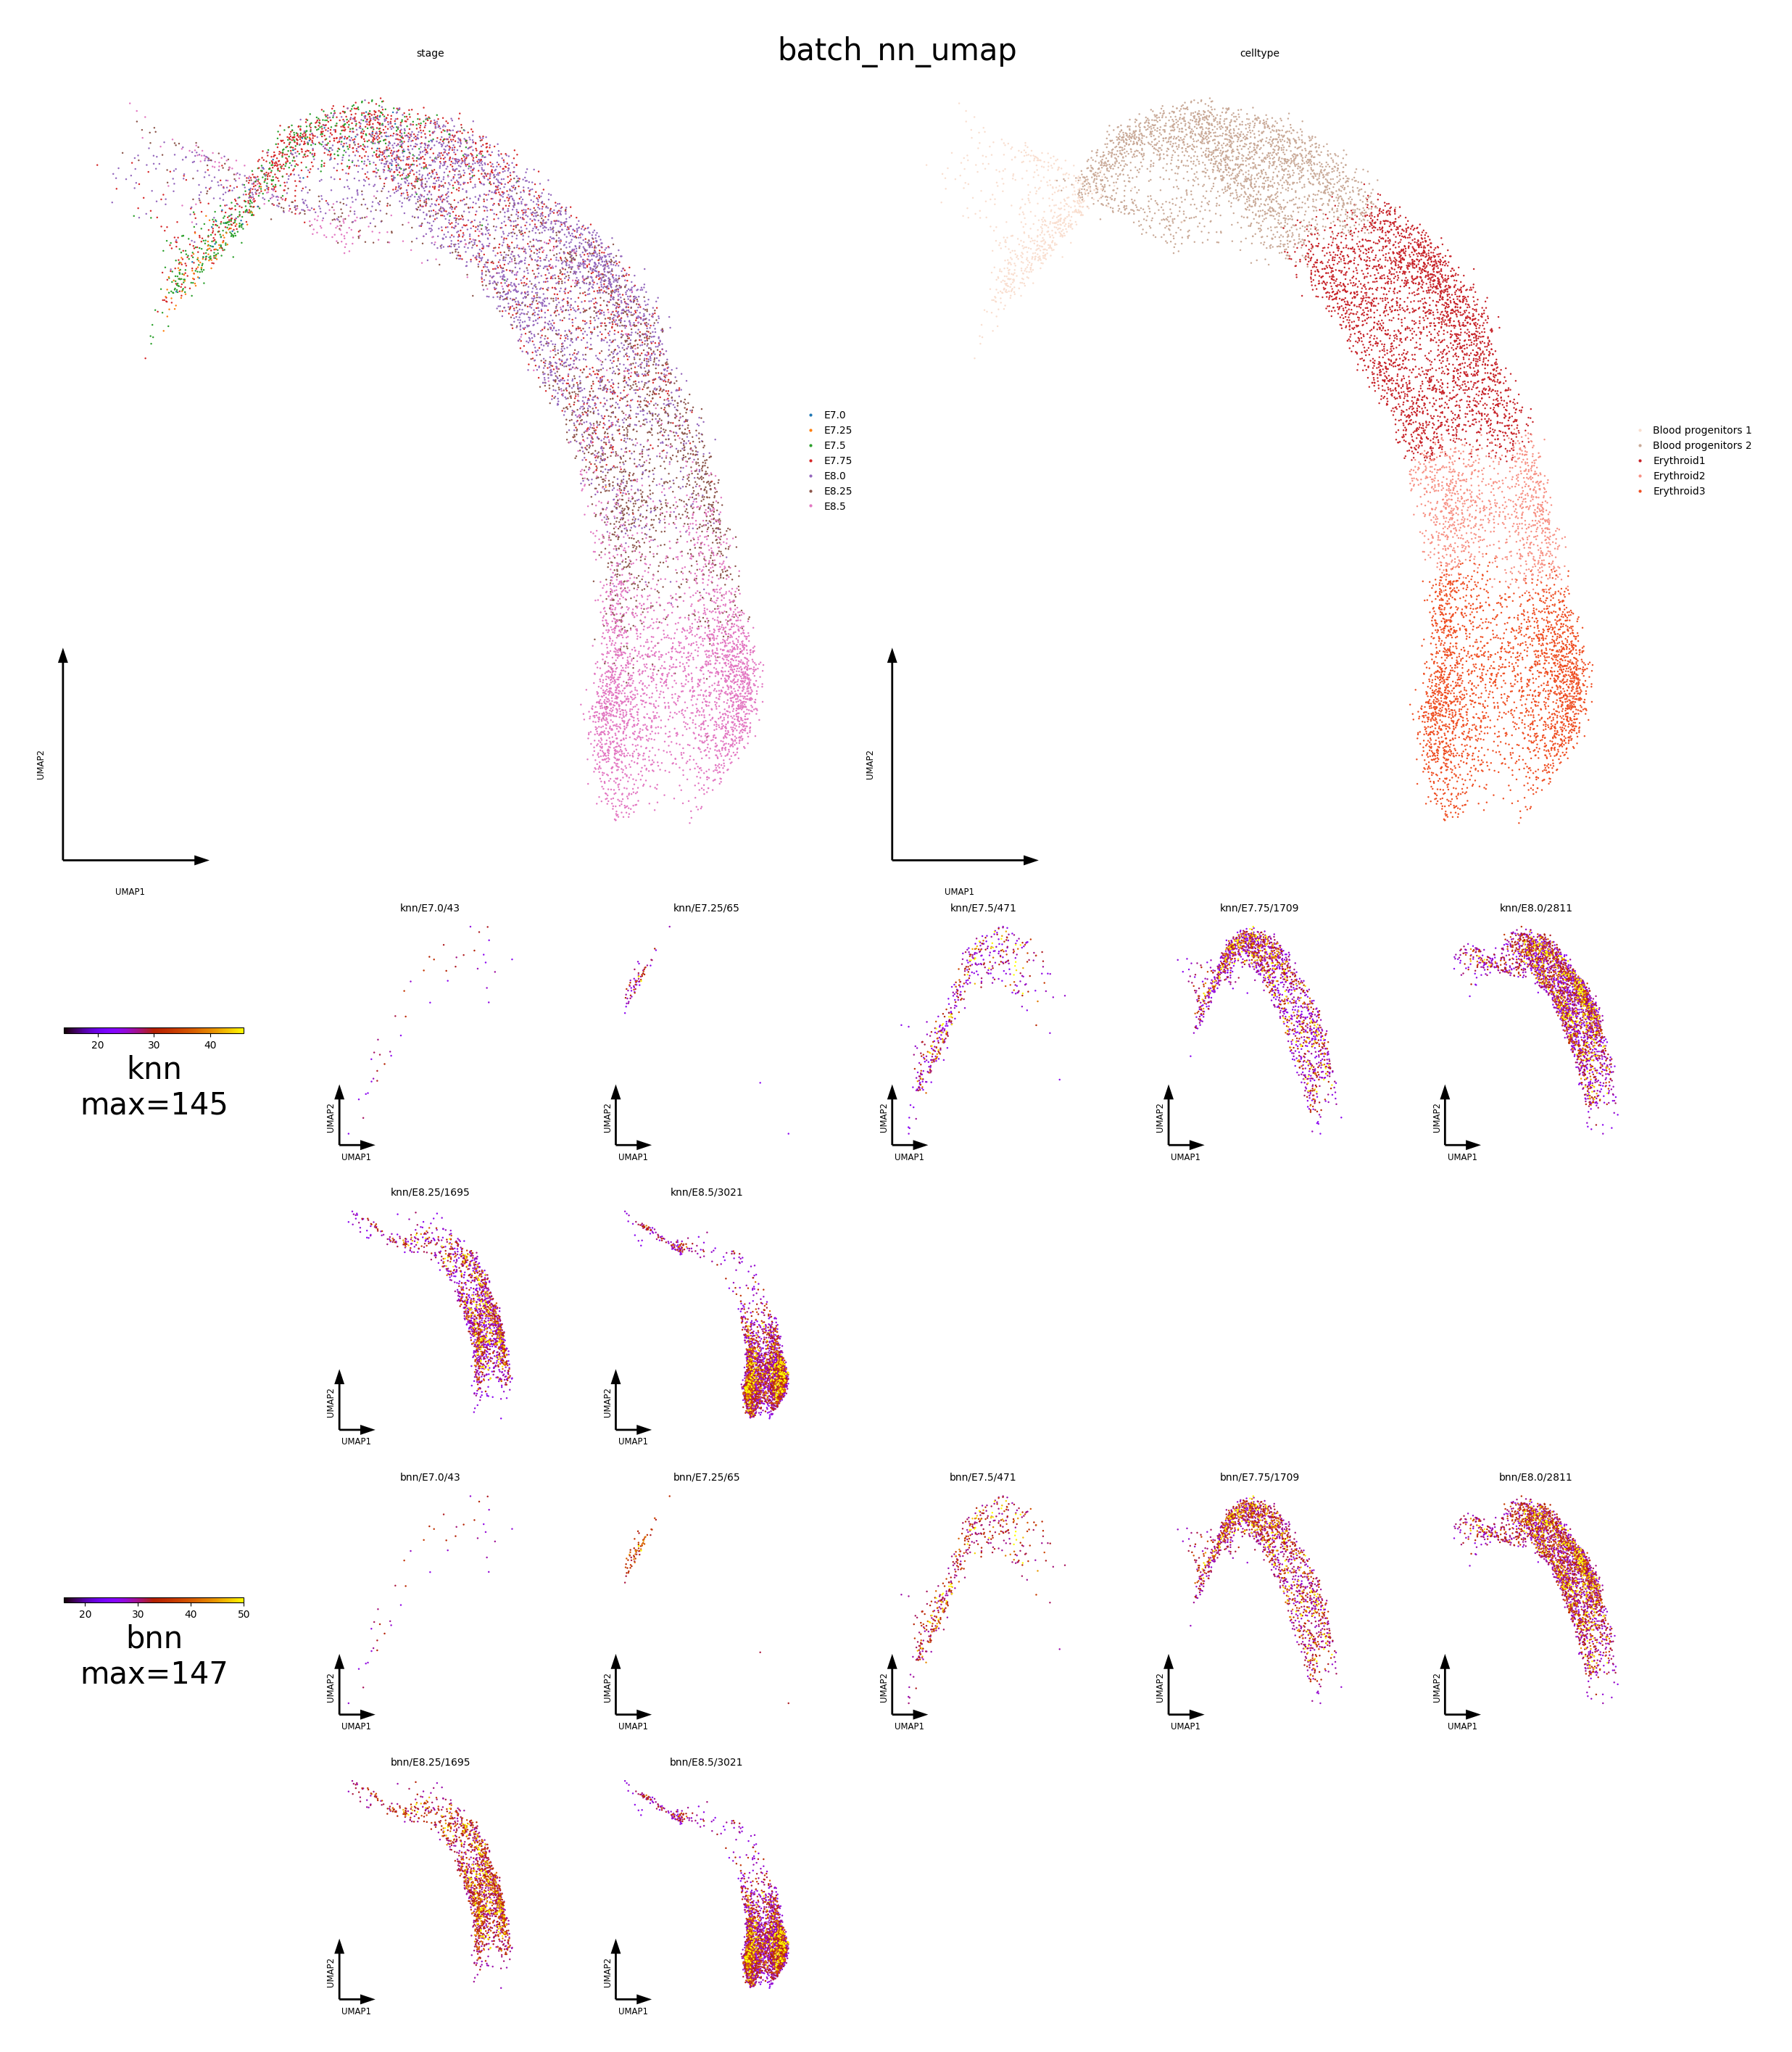

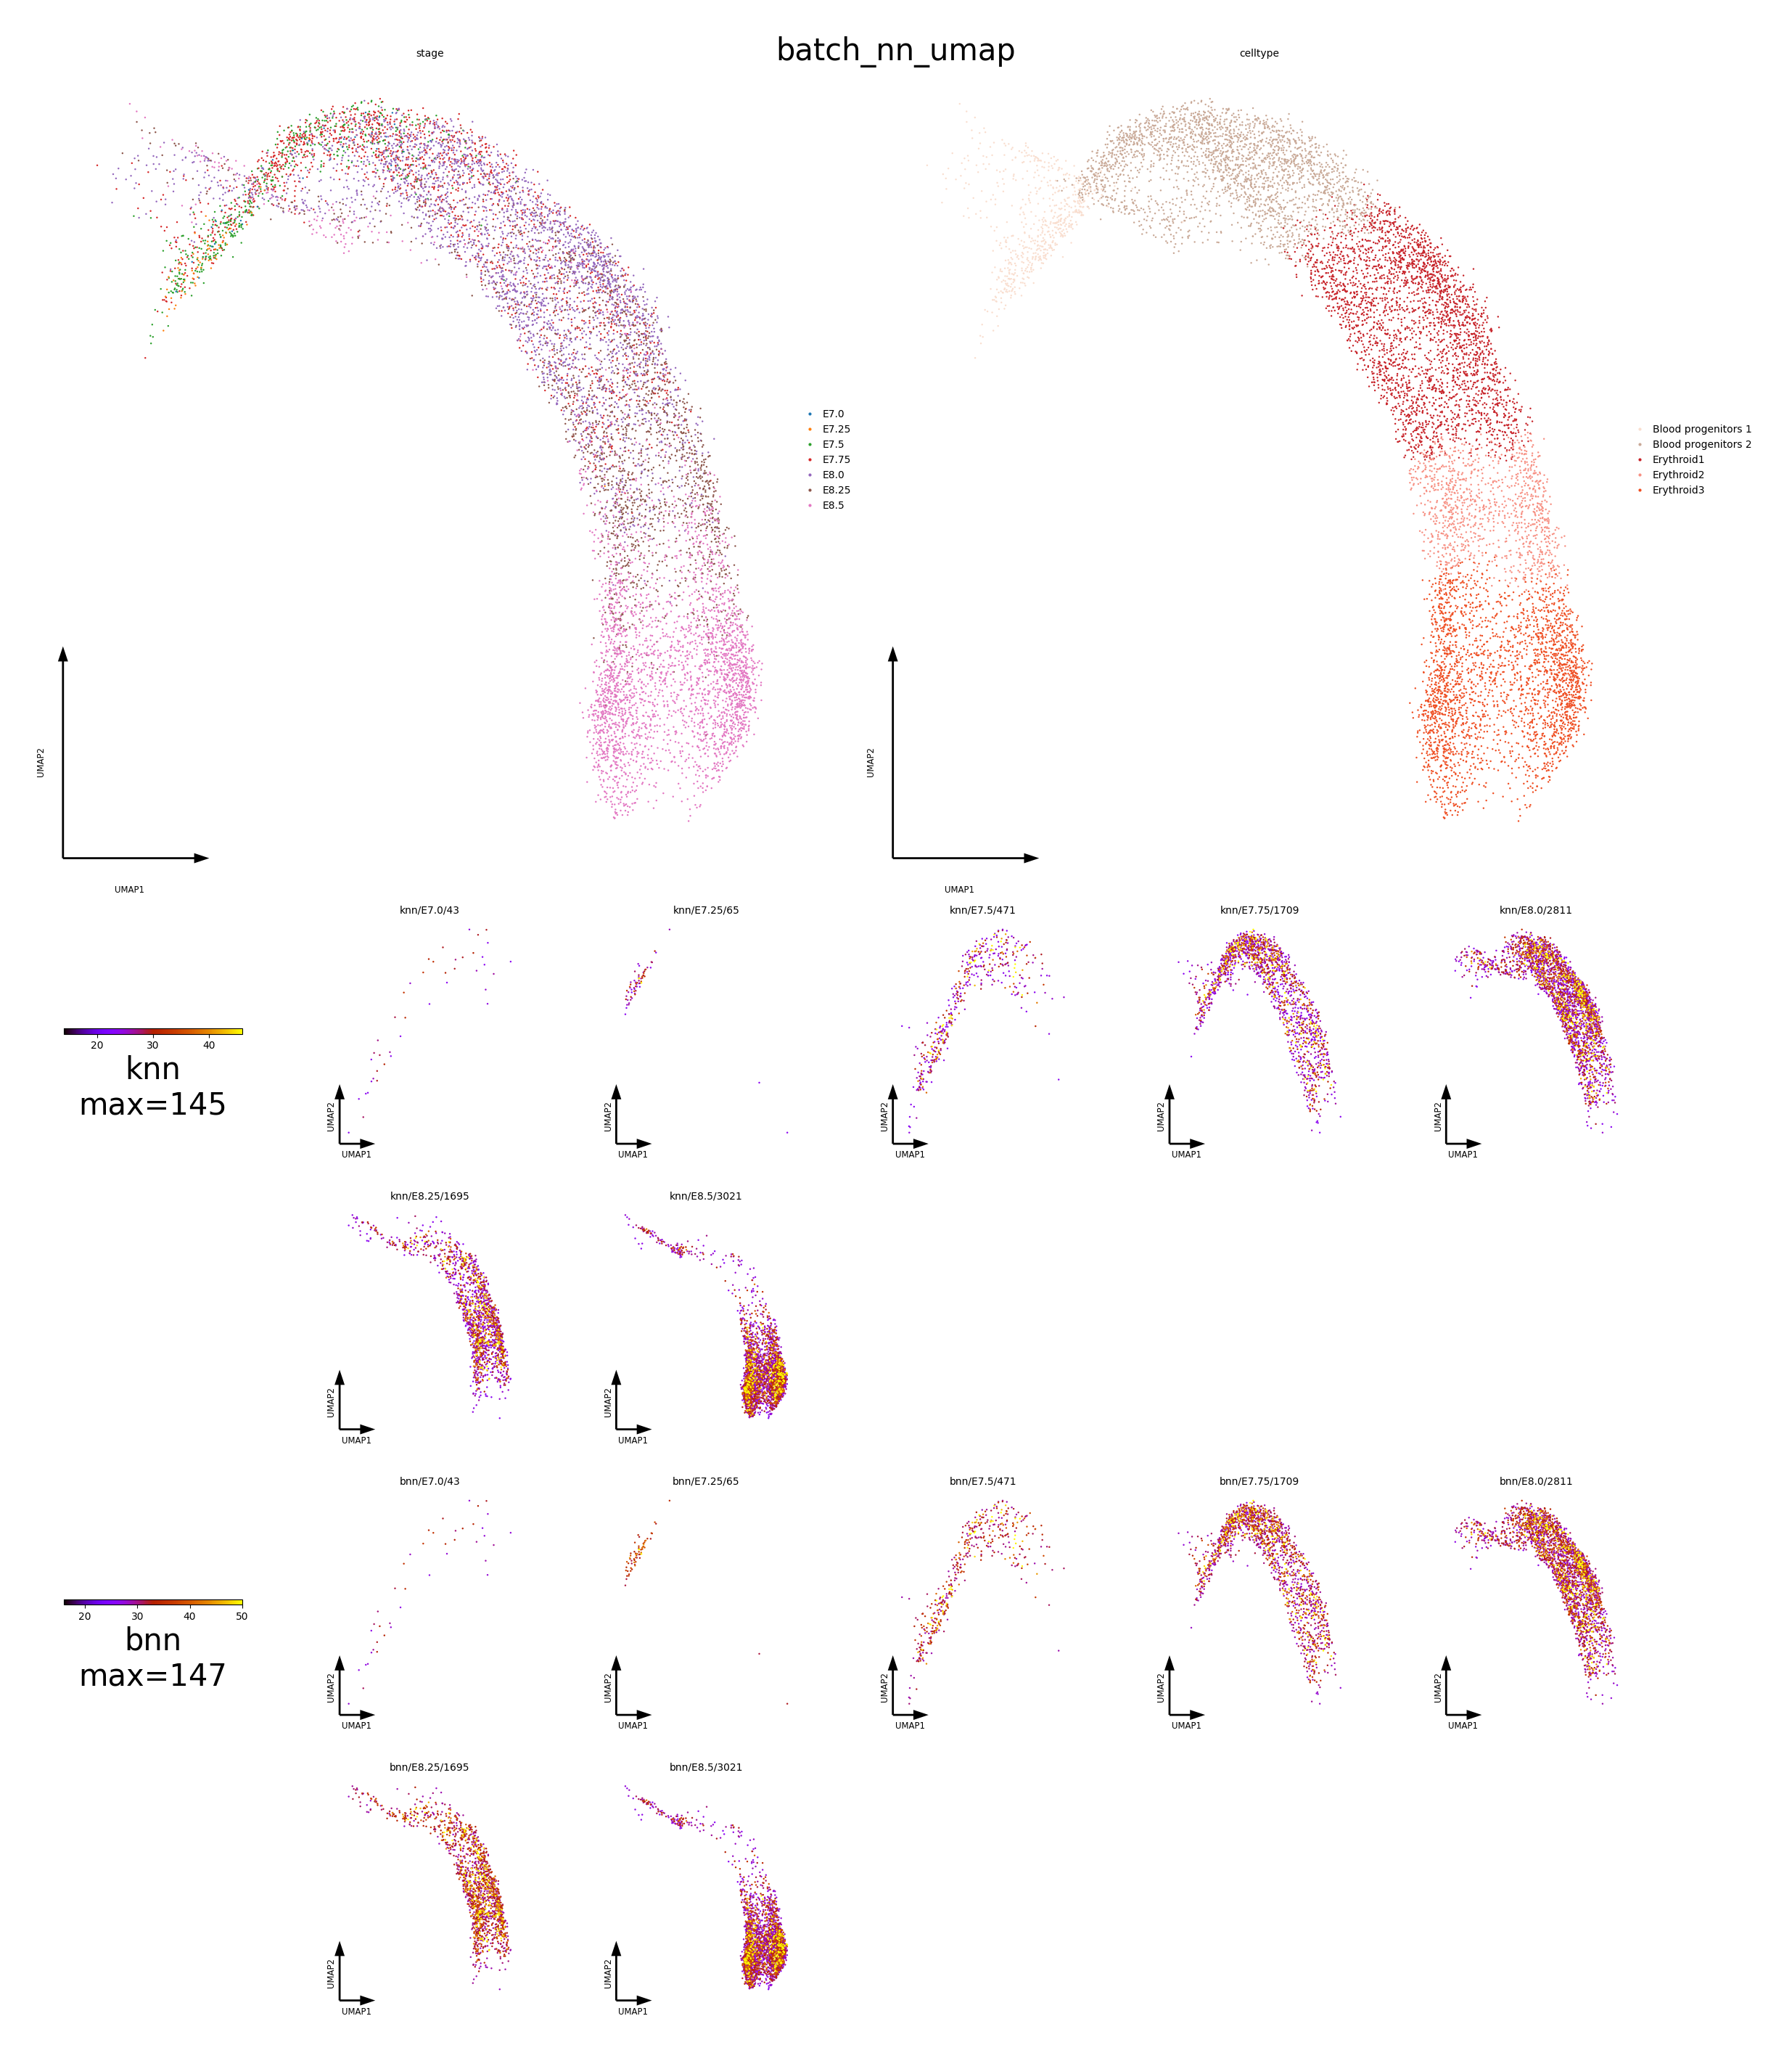

In [14]:
velovgi.pl.draw_batch_nn_umap(adata, batch_key=batch_key, cluster_key=cluster_key)

## 6. Saving Result

1. Anndata saving.

In [16]:
adata_dir = "./data/adata"
velovgi.tl.write_adata(adata, adata_dir)

create ./data/adata
save ./data/adata/sample_recover.pkl
save ./data/adata/adata.h5ad


In [18]:
adata = velovgi.tl.read_adata(adata_dir)
adata

load ./data/adata/adata.h5ad
load ./data/adata/sample_recover.pkl


AnnData object with n_obs × n_vars = 9815 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition', 'knn', 'bnn'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'neighbors', 'stage_colors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'sample_recover'
    obsm: 'X_pca', 'X_umap', 'X_umap_transformed_batch', 'velocity_umap'
    layers: 'Ms', 'Mu', 'fit_t', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

2. Model model saving. 

In [19]:
model_dir = "./model/base"
velovgi_model.save(model_dir)